# Modelling of melt volatile concentrations in porphyry Cu deposits from subduction and collision zones

## 1. Import libraries

In [7]:
!pip install periodictable
!pip install datashader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import lambertw
import periodictable as pt
import math as math
import seaborn as sb
import random as rd
from pylab import rcParams
import matplotlib.cm     as cm
import matplotlib as mpl
from time import sleep
from tqdm.notebook import tqdm
import datashader as ds
import datashader.transfer_functions as tf
import math

# Set random seed
rd.seed(1)

## 2. Define functions and calibrations

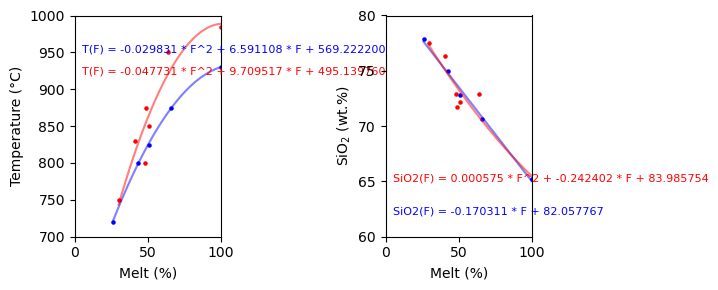

In [8]:
# Calibrate X-T-SiO2 relationship using experiments of Caricchi & BLundy (2015)
# water saturated
car_blu_sat_T = [930,875,825,800,720]
car_blu_sat_m = [100,66,51,43,26]
car_blu_sat_SiO2 = [65.24,70.68,72.80,74.97,77.89]

# Blundy and Caricchi water undersaturated
car_blu_T = pd.Series([750,800,830,850,875,950,985])
car_blu_m = pd.Series([30,48,41,51,49,64,100])
car_blu_SiO2 = pd.Series([77.54,72.93,76.36,72.14,71.76,72.87,65.24])

fig, axs = plt.subplots(1,2, figsize = (6.5,3))

axs[0].scatter(car_blu_m,car_blu_T, s = 5, color = 'r')
axs[0].scatter(car_blu_sat_m,car_blu_sat_T, s = 5, color = 'b')

# Saturated dataset fit 
x_test1 = np.linspace(np.min(car_blu_sat_m), np.max(car_blu_sat_m), 100)
fit1 = np.polyfit(car_blu_sat_m,car_blu_sat_T, 2)
aT = fit1[0] # assign constants
bT = fit1[1]
cT = fit1[2]
fit_equation1 = aT * x_test1**2 + bT * x_test1 + cT                    
y_testT = aT * x_test1**2 + bT * x_test1 + cT
axs[0].plot(x_test1, y_testT,color = 'b',alpha = 0.5)

fit2 = np.polyfit(car_blu_sat_m,car_blu_sat_SiO2, 1)
a2 = fit2[0] # assign constants
b2 = fit2[1]
fit_equation2 =  a2 * x_test1 + b2                  
y_test2 = a2 * x_test1 + b2
axs[1].plot(x_test1, y_test2,color = 'b',alpha = 0.5)

def calc_melt_F_SiO2_trend(SiO2):
    residual = SiO2-np.min(car_blu_sat_SiO2)
    a1, b1, c1 = np.polyfit(car_blu_sat_m,car_blu_sat_SiO2, 2) # fit data
    return(a1, b1, c1)

def calc_melt_SiO2_sat(a1, b1, c1, F):
    y1 =a1 * F**2 + b1 * F**1 + c1 * F**0
    return(y1)

def calc_T_sat(melt_fraction):    
    y = aT * melt_fraction**2 + bT * melt_fraction**1 + cT * melt_fraction**0
    return(y +273.15)

x_test2 = np.linspace(np.min(car_blu_m), np.max(car_blu_m), 100)
fit3 = np.polyfit(car_blu_m,car_blu_T, 2) 
a3 = fit3[0] # assign constants
b3 = fit3[1]
c3 = fit3[2]
# d2 = fit2[3]
fit_equation3 = a3 * x_test2**2 + b3 * x_test2 + c3                    
y_test3 = a3 * x_test2**2 + b3 * x_test2 + c3
axs[0].plot(x_test2, y_test3,color = 'r',alpha = 0.5)

def calc_T_undersat(melt_fraction):    
    y = a2 * melt_fraction**2 + b2 * melt_fraction + c2        
    return(y +273.15)

axs[0].set_xlim([0,100])
axs[0].set_ylim([700,1000])
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_xlabel('Melt (%)')

axs[1].scatter(car_blu_m, car_blu_SiO2,s = 5, color = 'r')
axs[1].scatter(car_blu_sat_m, car_blu_sat_SiO2,s = 5, color = 'b')
fit4 = np.polyfit(car_blu_m, car_blu_SiO2, 2)
a4= fit4[0] # assign constants
b4 = fit4[1]
c4 = fit4[2]
x_test = np.linspace(np.min(car_blu_m), np.max(car_blu_m), 100)
y_test4 = a4 * x_test**2 + b4 * x_test + c4
axs[1].plot(x_test, y_test4,color = 'r',alpha = 0.5)
axs[1].set_ylim([60,80])
axs[1].set_xlim([0,100])
axs[1].set_xlabel('Melt (%)')
axs[1].set_ylabel('$\mathregular{SiO_2 }$ (wt.%)')

# Display equations for both saturated and undersaturated conditions without recalculating

# Saturated condition equations
saturated_fit_eq_T = f"T(F) = {aT:.6f} * F^2 + {bT:.6f} * F + {cT:.6f}"
saturated_fit_eq_SiO2 = f"SiO2(F) = {a2:.6f} * F + {b2:.6f}"

# Undersaturated condition equations
undersat_fit_eq_T = f"T(F) = {a3:.6f} * F^2 + {b3:.6f} * F + {c3:.6f}"
undersat_fit_eq_SiO2 = f"SiO2(F) = {a4:.6f} * F^2 + {b4:.6f} * F + {c4:.6f}"

# Display equations as text annotations on the plot
axs[1].text(5, 62, saturated_fit_eq_SiO2, color='blue', fontsize=8)
axs[1].text(5, 65, undersat_fit_eq_SiO2, color='red', fontsize=8)
axs[0].text(5, 950, saturated_fit_eq_T, color='blue', fontsize=8)
axs[0].text(5, 920, undersat_fit_eq_T, color='red', fontsize=8)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('T-X-SiO2_Calibrations.svg', dpi = 1200)

## 3. Data processing

In [9]:
# Import data
probe_data = pd.read_csv('apatite mineral formula recalculation.csv')

# Data cleaning
probe_data = probe_data[(probe_data['F apfu'] <= 2) & (probe_data['Cl apfu'] <= 2) & (probe_data['est OH apfu'] <= 2)]
probe_data['XF'] = probe_data['F apfu'] / 2
probe_data['XCl'] = probe_data['Cl apfu'] / 2
probe_data['XH'] = probe_data['est OH apfu'] / 2

# Divided into col and arc groups
probe_data['Type'] = probe_data['Sample'].apply(lambda x: 'col' if 'col' in x.lower() else 'arc')
groups = probe_data.groupby('Type')

# Defined function
def calc_Cl_fluid(SiO2, P, Cl_melt):
    a, b, c = 0.4078, 0.1456, 34.47
    P0, D0 = 175.8, 0.0005862
    term1 = np.exp(a * Cl_melt + b * SiO2)
    term2 = 1 + np.exp((P0 - P) / c)
    DCl = D0 * (term1 / term2)
    Cl_fluid = DCl * Cl_melt
    NaCl_fluid = Cl_fluid * (58.44 / 35.45)
    return NaCl_fluid, DCl

def calc_critical_XNaCl(T):
    d8, d9, d10, d11 = 7.77761E-2, 2.7042E-4, -4.244821E-7, 2.580872E-10
    return d8 * (T - 600)**0 + d9 * (T - 600)**1 + d10 * (T - 600)**2 + d11 * (T - 600)**3

def calc_melt_halogen(XFAp, XClAp, XOHAp, T):
    R = 8.3145
    T += 273.15  
    WClOH, WFCl, WFOH = 5000, 16000, 7000
    act_F = np.exp(((XClAp * (1 - XFAp) * WFCl + XOHAp * (1 - XFAp) * WFOH - (XClAp * XOHAp) * WClOH)) / (R * T))
    act_Cl = np.exp(((XOHAp * (1 - XClAp) * WClOH + XFAp * (1 - XClAp) * WFCl - (XOHAp * XFAp) * WFOH)) / (R * T))
    act_OH = np.exp(((XClAp * (1 - XOHAp) * WClOH + XFAp * (1 - XOHAp) * WFOH - (XClAp * XFAp) * WFCl)) / (R * T))

    a, b = 72900, -34
    G_OHCl = a + b * T
    KdOHCl = math.exp(-G_OHCl / (R * T)) / (act_OH / act_Cl)

    a, b = 94600, -40
    G_OHF = a + b * T
    KdOHF = math.exp(-G_OHF / (R * T)) / (act_OH / act_F)

    KdClF = KdOHF / KdOHCl

    # Calculation of ratio in melt
    XFXOHmelt = (XFAp / XOHAp) / (1 / KdOHF)
    XClXOHmelt = (XClAp / XOHAp) / (1 / KdOHCl)
    XFXClmelt = (XFAp / XClAp) / (1 / KdClF)

    return XFXClmelt, XClXOHmelt, XFXOHmelt, KdOHCl, KdOHF, KdClF

# Calculate and store results
df_all = []

for name, group in groups:
    XFXClmelt_unit = []
    XClXOHmelt_unit = []
    XFXOHmelt_unit = []
    KdClOH_unit = []
    KdFOH_unit = []
    KdClF_unit = []

    for _, row in group.iterrows():
        T = row['T']
        XFXClmelt, XClXOHmelt, XFXOHmelt, KdClOH, KdFOH, KdClF = calc_melt_halogen(row['XF'], row['XCl'], row['XH'], T)
        
        XFXClmelt_unit.append(XFXClmelt)
        XClXOHmelt_unit.append(XClXOHmelt)
        XFXOHmelt_unit.append(XFXOHmelt)
        KdClOH_unit.append(KdClOH)
        KdFOH_unit.append(KdFOH)
        KdClF_unit.append(KdClF)

    df = pd.DataFrame({
        'Method': ['Combined'] * len(group),
        'Unit': [name] * len(group),
        'XF/XCl': XFXClmelt_unit,
        'XCl/XOH': XClXOHmelt_unit,
        'XF/XOH': XFXOHmelt_unit,
        'KdClOH': KdClOH_unit,
        'KdFOH': KdFOH_unit,
        'KdClF': KdClF_unit
    })
    df_all.append(df)

# Merge data
df = pd.concat(df_all, ignore_index=True)

# Calculate the 95% confidence interval
intervals = {}
for unit in ['arc', 'col']:
    unit_data = df[df['Unit'] == unit]
    intervals[unit] = {
        'XF/XCl': (unit_data['XF/XCl'].quantile(0.05), unit_data['XF/XCl'].quantile(0.95)),
        'XCl/XOH': (unit_data['XCl/XOH'].quantile(0.05), unit_data['XCl/XOH'].quantile(0.95)),
        'XF/XOH': (unit_data['XF/XOH'].quantile(0.05), unit_data['XF/XOH'].quantile(0.95))
    }

    
    
print("95% confidence interval:", intervals)

combined_data = df[df['Unit'].isin(['arc', 'col'])]

XFXCl_min = combined_data['XF/XCl'].quantile(0.05)
XFXCl_max = combined_data['XF/XCl'].quantile(0.95)
XClXOH_min = combined_data['XCl/XOH'].quantile(0.05)
XClXOH_max = combined_data['XCl/XOH'].quantile(0.95)
XFXOH_min = combined_data['XF/XOH'].quantile(0.05)
XFXOH_max = combined_data['XF/XOH'].quantile(0.95)

combined_data.to_csv("combined_results.csv", index=False)

95% confidence interval: {'arc': {'XF/XCl': (0.24848701478963242, 0.812144630880527), 'XCl/XOH': (0.015494801536196635, 0.07982987427296324), 'XF/XOH': (0.0071132569081560236, 0.03265416389252212)}, 'col': {'XF/XCl': (0.7970914069230953, 12.461206440403009), 'XCl/XOH': (0.0015011343571299139, 0.03189143337724227), 'XF/XOH': (0.012480764213834596, 0.043075000284986426)}}


## 4. Water-saturated Monte Carlo modelling

  0%|          | 0/50 [00:00<?, ?it/s]

saturated 0.7056112756690079 0.09528062292414394 945.799872629247
saturated 0.3999055486282705 0.09283422522672116 934.5268416900084


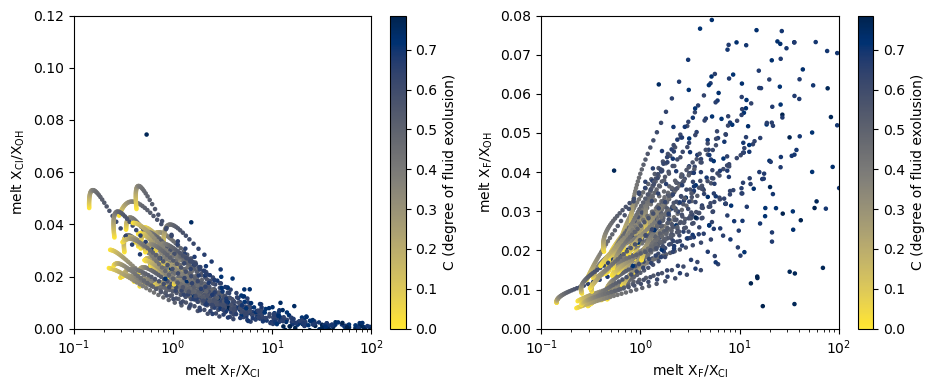

In [10]:
# Numerical model

# Define parameters
# % Cl at saturation
Cl_sat_min = 0.2
Cl_sat_max = 0.6
range_Cl_sat = np.random.uniform(Cl_sat_min, Cl_sat_max, 100)
# % F at saturation
F_sat_min = 0.04
F_sat_max = 0.18
range_F_sat = np.random.uniform(F_sat_min, F_sat_max, 100)
DH2Ominmelt_min = 0.01
DH2Ominmelt_max = 0.1
range_DH2Ominmelt = np.random.uniform(DH2Ominmelt_min, DH2Ominmelt_max, 100)

# SiO2 range = dacite
range_SiO2 = np.random.uniform(65,78,100)


# Pressure Mpa
P_min = 165
P_max = 300
range_P = np.random.uniform(P_min, P_max, 100)

DF_min = 0.01
DF_max = 1
range_DF = np.random.uniform(DF_min, DF_max, 100)

melt_density = 2500
gas_molar_volume = 0.018 # for water (molar mass/1)
DClminmelt_min = 0.02
DClminmelt_max = 0.5
range_DClminmelt = np.random.uniform(DClminmelt_min, DClminmelt_max, 100)

DFminmelt_min = 0.15
DFminmelt_max = 0.65
range_DFminmelt = np.random.uniform(DFminmelt_min, DFminmelt_max, 100)

Cu_melt_min = 10
Cu_melt_max = 150 #ppm
range_Cu_melt = np.random.uniform(Cu_melt_min, Cu_melt_max, 100)
DCuminmelt_min = 0.2
DCuminmelt_max = 2
range_DCuminmelt = np.random.uniform(DCuminmelt_min, DCuminmelt_max, 100)

Pd_melt_min = 1
Pd_melt_max = 10 #ppm
range_Pd_melt = np.random.uniform(Pd_melt_min, Pd_melt_max, 100)
DPdliqmelt_min = 1
DPdliqmelt_max = 10
range_DPdliqmelt = np.random.uniform(DPdliqmelt_min, DPdliqmelt_max, 100)

start_crst = 0
end_crst = 0.87
crst_increments = 0.01 # steps in model
monte_carlo_run_total = 50

monte_carlo_run = 0

fig, axs = plt.subplots(1,2, figsize = [9.5,4])

axr = axs.ravel()

# empty arrays to put porphyry matching simulations
Cl_sat_filter = []
F_sat_filter = []
H2O_sat_filter = []
crst_filter = []
SiO2_filter = []
P_filter = []
# empty arrays for non matching simulations
Cl_sat_unfilter = []
F_sat_unfilter = []
H2O_sat_unfilter = []
P_unfilter = []
H2O_ex_all = []
Cl_fluid_all = []
Cu_fluid_all = []
Cu_melts_all = []
Pd_melts_all = []
crst_unfilter = []
SiO2_unfilter = []
pbar = tqdm(total = monte_carlo_run_total)
while monte_carlo_run < monte_carlo_run_total:
    crst = 0
    # initialise empty lists to fill
    Cl_melt_list = []
    F_melt_list = []
    Cl_melt_crst_list = []
    Cl_melt_degas_list = []
    crst_all = []
    SiO2_all = []
    Cl_fluid_list = []
    Cu_fluid_list = []
    Cu_melts_list = []
    Pd_melts_list = []
    H2O_wt_exslv_list = []
    H2O_ex_list = []
    # pick parameters randomly from set ranges
    P = rd.choice(range_P)
    Cl_sat = rd.choice(range_Cl_sat)
    H2O_sat =  0.0171948701*P + 2.35551895
    F_sat = rd.choice(range_F_sat)
    DClminmelt = rd.choice(range_DClminmelt)
    DH2Ominmelt = rd.choice(range_DH2Ominmelt)
    DFminmelt = rd.choice(range_DFminmelt)
    DF = rd.choice(range_DF)
    initial_SiO2 = rd.choice(range_SiO2)
    a1, b1, c1 = calc_melt_F_SiO2_trend(initial_SiO2)
    # run model until reaches 60% crystallinity
    while crst < end_crst:
        SiO2 = calc_melt_SiO2_sat(a1, b1, c1,(1-crst)*100)
        if crst == 0: # if this is the first iteration use Cl at saturation
            Cl_melt_prev = Cl_sat
            F_melt_prev = F_sat
        else:
            Cl_melt_prev = Cl_melt_list[-1] # use previous step Cl melt
            F_melt_prev = F_melt_list[-1]
        # Now, carry out model as described in text
        T = calc_T_sat((1-crst)*100) # temperature as a function of crystallinity
        density_vol = (gas_molar_volume*P*10**6)/(T+273.15*8.314) # Popa Eq 9
        NaCl_fluid, DCl = calc_Cl_fluid(SiO2, P, Cl_melt_prev) # Calculate DCl from Tattich et al.
        XNaCl_fluid = (NaCl_fluid/pt.formula("NaCl").mass) / ((NaCl_fluid/pt.formula("NaCl").mass) + ((100-NaCl_fluid)/pt.formula("H2O").mass)) # mole fraction NaCl
        if XNaCl_fluid > calc_critical_XNaCl(T): # is it brine saturated?
            print('saturated', XNaCl_fluid, calc_critical_XNaCl(T-273.15), T)
        Cl_fluid = NaCl_fluid/(pt.formula("NaCl").mass/pt.formula("Cl").mass) # Convert NaCl to Cl
        H2Omelt = H2O_sat/(DH2Ominmelt + (1-crst)*(1-DH2Ominmelt)) # H2O in melt after crystallisation
        H2O_wt_exslv = (H2Omelt-H2O_sat)/100 # mass balance
        H2O_vol_exslv = H2O_wt_exslv/(density_vol/melt_density) # Popa Eq 10 - % vol exsolved water
        m_melt = 1-(H2O_wt_exslv + crst) # volume % of melt - mass balance
        H2O_ex = H2O_wt_exslv/(H2Omelt/100)
        
        # Calculate bulk DCl for melt and fluid - equation from Tattich et al.
        bulk_DCl = DClminmelt*(1 - (H2O_sat/100)*(100/(100-NaCl_fluid)))+DCl.real*(H2O_sat/100)*(100/(100-NaCl_fluid.real)) # calc bulk D Cl
        bulk_DF = (DFminmelt*(1-(H2O_sat/100)))+(DF*(H2O_sat/100)) # calc bulk D F *****
        Cl_melt = Cl_melt_prev/(bulk_DCl+(m_melt/(m_melt+crst_increments))*(1-bulk_DCl)) # Update Cl melt
        F_melt = F_melt_prev/(bulk_DF+(m_melt/(m_melt+crst_increments))*(1-bulk_DF)) # Update F melt
        melt_molar_mass = 32.5 # Can vary between 32.5 and 36.6 for a rhyolite
        # Calculate Cu in fluid
        Cu_melt = rd.choice(range_Cu_melt)
        XH2O_fluid = 1
        DCu_fluid = 8*(10**4)*(((NaCl_fluid.real/300)**2)*(XH2O_fluid**14))+380*(NaCl_fluid.real/300)+0.8 # Calc DCu using Tattitch & Blundy
        DCuminmelt = rd.choice(range_DCuminmelt)
        bulk_DCu = DCuminmelt*((1-(H2O_sat/100))*(100/(100-NaCl_fluid.real)))+DCu_fluid*(H2O_sat/100)*(100/(100-NaCl_fluid.real)) # calc bulk D Cu
        Cu_fluid = bulk_DCu*Cu_melt # in ppm   
        Cu_min = Cu_melt*DCuminmelt
        Cu_melts = (Cu_melt/10000*1-Cu_fluid/10000*H2O_wt_exslv-Cu_min/10000*crst)/m_melt*10000
        # Calculate Pd in melt
        Pd_melt = rd.choice(range_Pd_melt)
        DPdliqmelt = rd.choice(range_DPdliqmelt)
        Pd_melts = Pd_melt*1*(1-H2O_wt_exslv)/((1-H2O_wt_exslv)+DPdliqmelt*H2O_wt_exslv)
        
        Cl_melt_list.append(Cl_melt)
        Cl_fluid_list.append(Cl_fluid.real)
        Cu_fluid_list.append(Cu_fluid)
        Cu_melts_list.append(Cu_melts)
        Pd_melts_list.append(Pd_melts)
        F_melt_list.append(F_melt)
        crst_all.append(crst)
        SiO2_all.append(SiO2)
        H2O_wt_exslv_list.append(H2O_wt_exslv)
        H2O_ex_list.append(H2O_ex)
        crst = crst + crst_increments # next increment
        
    # convert conc to mol
    mol_Cl =  [i/pt.formula("Cl").mass/(100/melt_molar_mass) for i in Cl_melt_list] 
    mol_F =  [i/pt.formula("F").mass/(100/melt_molar_mass) for i in F_melt_list]
    H2O_melt = np.empty(len(mol_Cl))
    H2O_melt.fill(H2O_sat)

    # Calculate moles of H2O using Zhang et al. 2012
    mol_H2O_melt = (H2O_melt/pt.formula("H2O").mass)/((H2O_melt/pt.formula("H2O").mass)+((100-H2O_melt)/melt_molar_mass))

    # equilibrium constant lnK = a + bK for H2O disassociation
    K2 = rd.choice(np.random.uniform(0.44, 0.52, 100))
    # calculate XOH using Li and Hermann 2015:
    mol_OH_melt = (0.5-np.sqrt(0.25-(((K2-4)/K2)*(mol_H2O_melt-mol_H2O_melt**2))))/((K2-4)/(2*K2))
    
    #calc ratios
    FCl_ratio = np.divide(mol_F,mol_Cl)
    ClOH_ratio = np.divide(mol_Cl,mol_OH_melt)
    FOH_ratio = np.divide(mol_F,mol_OH_melt)
    
    # Filter for values that are within the porphyry range
    FCl_filter = np.any(np.where((FCl_ratio > XFXCl_min) & (FCl_ratio < XFXCl_max),
                          True, False))
    ClOH_filter = np.any(np.where((ClOH_ratio > XClXOH_min) & (ClOH_ratio < XClXOH_max),
                          True, False))
    FOH_filter = np.any(np.where((FOH_ratio > XFXOH_min) & (FOH_ratio < XFXOH_max),
                          True, False))
    if FCl_filter == True and ClOH_filter == True and FOH_filter == True:
        Cl_sat_filter.append(Cl_sat)
        F_sat_filter.append(F_sat)
        H2O_sat_filter.append(H2O_sat)
        P_filter.append(P)
    # else:
    Cl_sat_unfilter.append(Cl_sat)
    F_sat_unfilter.append(F_sat)
    H2O_sat_unfilter.append(H2O_sat)
    P_unfilter.append(P)
    
    H2O_ex_all.append(H2O_ex_list)
    Cl_fluid_all.append(Cl_fluid_list)
    Cu_fluid_all.append(Cu_fluid_list)
    Cu_melts_all.append(Cu_melts_list)
    Pd_melts_all.append(Pd_melts_list)
    
    # try to filter for crystallisation 
    fil1 = np.where((FCl_ratio > XFXCl_min) & (FCl_ratio < XFXCl_max),True, False)
    fil2 = np.where((ClOH_ratio > XClXOH_min) & (ClOH_ratio < XClXOH_max),True, False)
    fil3 = np.where((FOH_ratio > XFXOH_min) & (FOH_ratio < XFXOH_max),True, False)
    filtotal = np.where((fil1==True)&(fil2==True)&(fil3==True), True, False)
    
    if np.any(filtotal):
        index = np.argwhere(filtotal==True).flatten()
        crst_filter.append(np.array(crst_all)[index].flatten())
        SiO2_filter.append(np.array(SiO2_all)[index].flatten())
    # else:
    index = np.argwhere(filtotal==False).flatten()
    crst_unfilter.append(np.array(crst_all)[index].flatten())
    SiO2_unfilter.append(np.array(SiO2_all)[index].flatten())
    
    
    FCl_ratio_sampled = FCl_ratio[::2]
    ClOH_ratio_sampled = ClOH_ratio[::2]
    FOH_ratio_sampled = FOH_ratio[::2]
    H2O_ex_list_sampled = H2O_ex_list[::2]
    Cl_fluid_list_sampled = Cl_fluid_list[::2]
    Cu_fluid_list_sampled = Cu_fluid_list[::2]
    axr[0].scatter(FCl_ratio_sampled,ClOH_ratio_sampled, c = H2O_ex_list_sampled, cmap = 'cividis_r', s = 5, rasterized = True)
    axr[0].set_xscale('log')  
    axr[1].scatter(FCl_ratio_sampled,FOH_ratio_sampled, c = H2O_ex_list_sampled, cmap = 'cividis_r', s = 5, rasterized = True)
    axr[1].set_xscale('log') 
      
    # Prepare for next simulation
    monte_carlo_run = monte_carlo_run + 1
    pbar.update(1)


crst_filter_all = np.concatenate(crst_filter).ravel()

axr[0].set_ylabel('melt $\mathregular{X_{Cl}}$/$\mathregular{X_{OH}}$')
axr[0].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')

axr[1].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')
axr[1].set_ylabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{OH}}$')

axr[0].set_ylim([0,0.12])
axr[0].set_xlim([0.1,100])

axr[1].set_xlim([0.1,100])
axr[1].set_ylim([0,0.08])

cbar = fig.colorbar(ax=axr[0], mappable = axr[0].collections[0])
cbar.ax.set_ylabel('C (degree of fluid exolusion)', rotation=90)
cbar = fig.colorbar(ax=axr[1], mappable = axr[1].collections[0])
cbar.ax.set_ylabel('C (degree of fluid exolusion)', rotation=90)


fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('Water-saturated results.svg', dpi=1200)

plt.show()
pbar.close()


## 5. Water-unsaturated Monte Carlo modelling

  0%|          | 0/50 [00:00<?, ?it/s]

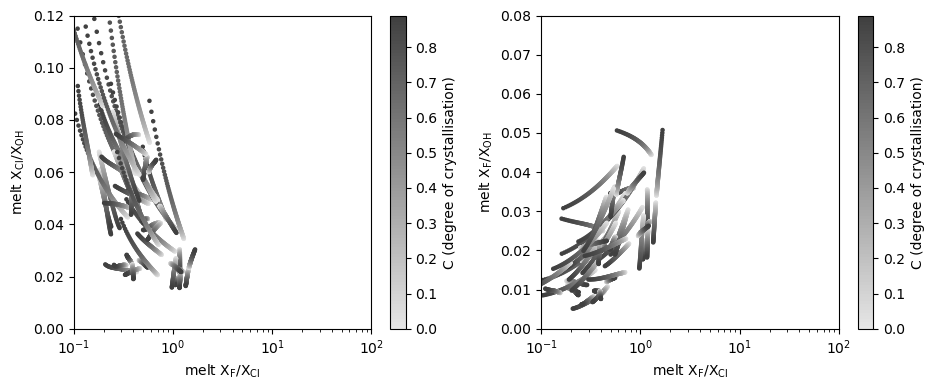

In [11]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0.9, 0.9, 0.9), (0.25, 0.25, 0.25)]
n_bins = 100
cmap_name = 'custom_grey'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Numerical model

# Define parameters
# % Cl at saturation
Cl_min = 0.2
Cl_max = 0.6
range_Cl = np.random.uniform(Cl_min, Cl_max, 100)
# % F at saturation
F_min = 0.04
F_max = 0.18
range_F = np.random.uniform(F_min, F_max, 100)
# H2O at saturation
H2O_min = 2
H2O_max = 4 # Chelle-Michou & Rottier pre-print
range_H2O = np.random.uniform(H2O_min, H2O_max, 100)

DH2Ominmelt_min = 0.01
DH2Ominmelt_max = 0.1
range_DH2Ominmelt = np.random.uniform(DH2Ominmelt_min, DH2Ominmelt_max, 100)

# SiO2 range = dacite
range_SiO2 = np.random.uniform(65,78,100)


# Pressure Mpa
P_min = 165
P_max = 300
range_P = np.random.uniform(P_min, P_max, 100)

# Experiments have
# determined that the partition coefficient for the distribution
# of F between aqueous or saline fluids and silicate melts
# (DFfl/mt) should be <0.1 at 200–500 MPa (Webster and Holloway, 1990; Webster, 1990).
# Going to allow DF to vary between 0.01 and 0.5 for now (fluid/melt)
DF_min = 0.01
DF_max = 0.1
range_DF = np.random.uniform(DF_min, DF_max, 100)

melt_density = 2500
gas_molar_volume = 0.018 # for water (molar mass/1)
DClminmelt_min = 0.02
DClminmelt_max = 0.5
range_DClminmelt = np.random.uniform(DClminmelt_min, DClminmelt_max, 100)

DFminmelt_min = 0.15
DFminmelt_max = 0.65
range_DFminmelt = np.random.uniform(DFminmelt_min, DFminmelt_max, 100)

Cu_melt_min = 10
Cu_melt_max = 150 #ppm
range_Cu_melt = np.random.uniform(Cu_melt_min, Cu_melt_max, 100)
DCuminmelt_min = 0.2
DCuminmelt_max = 2
range_DCuminmelt = np.random.uniform(DCuminmelt_min, DCuminmelt_max, 100)

start_crst = 0
end_crst = 0.90
crst_increments = 0.01 # steps in model
monte_carlo_run_total = 50
monte_carlo_run = 0
fig1, axs1 = plt.subplots(1,2, figsize = [9.5,4])
axr1 = axs1.ravel()


pbar = tqdm(total = monte_carlo_run_total)
while monte_carlo_run < monte_carlo_run_total:
    crst = 0
    # initialise empty lists to fill
    Cl_melt_list = []
    F_melt_list = []
    H2O_melt_list = []
    Cl_melt_crst_list = []
    Cl_melt_degas_list = []
    crst_all = []
    # pick parameters randomly from set ranges
    P = rd.choice(range_P)
    Cl_start = rd.choice(range_Cl)
    H2O_start =  rd.choice(range_H2O)
    F_start = rd.choice(range_F)
    DClminmelt = rd.choice(range_DClminmelt)
    DFminmelt = rd.choice(range_DFminmelt)
    DH2Ominmelt = rd.choice(range_DH2Ominmelt)
    initial_SiO2 = rd.choice(range_SiO2)
    a1, b1, c1 = calc_melt_F_SiO2_trend(initial_SiO2)
    # run model until reaches 60% crystallinity
    while crst < end_crst:
        SiO2 = calc_melt_SiO2_sat(a1, b1, c1,(1-crst)*100)
        T = calc_T_sat((1-crst)*100) # temperature as a function of crystallinity
        H2Omelt = H2O_start/(DH2Ominmelt + (1-crst)*(1-DH2Ominmelt)) # H2O in melt after crystallisation
        Cl_melt = Cl_start/(DClminmelt + (1-crst)*(1-DClminmelt)) # H2O in melt after crystallisation
        F_melt = F_start/(DFminmelt + (1-crst)*(1-DFminmelt)) # H2O in melt after crystallisation
        melt_molar_mass = 32.5 # Can vary between 32.5 and 36.6 for a rhyolite
        Cl_melt_list.append(Cl_melt)
        F_melt_list.append(F_melt)
        H2O_melt_list.append(H2Omelt)
        crst_all.append(crst)
        crst = crst + crst_increments # next increment

    mol_Cl =  [i/pt.formula("Cl").mass/(100/melt_molar_mass) for i in Cl_melt_list]
    mol_F =  [i/pt.formula("F").mass/(100/melt_molar_mass) for i in F_melt_list]

    # Calculate moles of H2O using Zhang et al. 2012
    H2O_melt_list = np.array(H2O_melt_list)
    mol_H2O_melt = (H2O_melt_list/pt.formula("H2O").mass)/((H2O_melt_list/pt.formula("H2O").mass)+((100-H2O_melt_list)/melt_molar_mass))

    # equilibrium constant lnK = a + bK for H2O disassociation
    K2 = rd.choice(np.random.uniform(0.44, 0.52, 100)) # varies between 0.44 and 0.52 for dacitic to rhyolitic melts
    # calculate XOH using Li and Hermann 2015:
    mol_OH_melt = (0.5-np.sqrt(0.25-(((K2-4)/K2)*(mol_H2O_melt-mol_H2O_melt**2))))/((K2-4)/(2*K2))

    FCl_ratio = np.divide(mol_F,mol_Cl)
    ClOH_ratio = np.divide(mol_Cl, mol_OH_melt)
    FOH_ratio = np.divide(mol_F, mol_OH_melt)
    FCl_ratio_sampled = FCl_ratio[::1]
    ClOH_ratio_sampled = ClOH_ratio[::1]
    FOH_ratio_sampled = FOH_ratio[::1]
    crst_all_sampled = crst_all[::1]

    # axr[4].plot(crst_all, FOH_ratio, 'grey')
    axr1[0].scatter(FCl_ratio_sampled, ClOH_ratio_sampled, c = crst_all_sampled, cmap=cmap, s = 5, rasterized = True)
    axr1[0].set_xscale('log')  
   
    axr1[1].scatter(FCl_ratio_sampled, FOH_ratio_sampled, c = crst_all_sampled, cmap=cmap, s = 5, rasterized = True)
    axr1[1].set_xscale('log')  
    monte_carlo_run = monte_carlo_run + 1
    pbar.update(1)


axr1[0].set_ylabel('melt $\mathregular{X_{Cl}}$/$\mathregular{X_{OH}}$')
axr1[0].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')

axr1[1].set_ylabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{OH}}$')
axr1[1].set_xlabel('melt $\mathregular{X_{F}}$/$\mathregular{X_{Cl}}$')
axr1[0].set_ylim([0,0.12])

axr1[0].set_xlim([0.1,100])

axr1[1].set_ylim([0,0.08])
axr1[1].set_xlim([0.1,100])
cbar = fig1.colorbar(ax=axr1[0], mappable = axr1[0].collections[0])
cbar.ax.set_ylabel('C (degree of crystallisation)', rotation=90)
cbar = fig1.colorbar(ax=axr1[1], mappable = axr1[1].collections[0])
cbar.ax.set_ylabel('C (degree of crystallisation)', rotation=90)


fig1.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig1.savefig('Water-unsaturated results.svg', dpi=1200)

plt.show()